In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.neighbors import KernelDensity

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
%system free -m

['              total        used        free      shared  buff/cache   available',
 'Mem:        1548094       23114     1496224        2732       28755     1520094',
 'Swap:         49151          46       49105']

In [4]:
#######################################################
# Define important input paramaters####################
# define the target AMOC range#########################
#######################################################

AMOC_range = 140

print('the RANGE of AMOC observation is', AMOC_range)

the RANGE of AMOC observation is 140


In [5]:
path_str = 'AMOC_'+str(AMOC_range)+'_years/'
print(path_str)

# Input data load path
input_file = 'input_data/'+path_str

# Hyper-parameter tuning data saving path
hyper_path = 'hyper_tuning/'+path_str

# large output data saving path
outDATA_path = '../model_output/'+path_str

AMOC_140_years/


[]

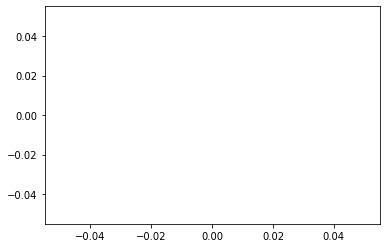

In [6]:
# change font size plt, need to run two times for old version matplotlib :)

# check: https://matplotlib.org/stable/api/matplotlib_configuration_api.html#matplotlib.rcParams for systematically change plot format
# font = {'size': 12}
plt.rcParams.update({'font.size':16, 'legend.fontsize':12})
plt.plot()

[]

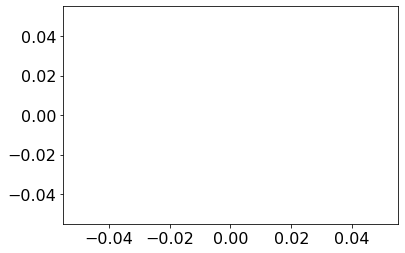

In [7]:
plt.rcParams.update({'font.size':16, 'legend.fontsize':12})
plt.plot()

In [8]:
# os.getcwd()

In [9]:
# load data
AMOC_Obs = pd.read_csv(input_file+'dtdata_AMOC_Obs.csv', index_col = 0)
AMOC_Ensemble = pd.read_csv(input_file+'dtdata_AMOC_Ensemble.csv', index_col = 0)

AMOCindex_Obs = pd.read_csv(input_file+'dtdata_AMOCindex_Obs.csv', index_col = 0)
AMOCindex_Ensemble = pd.read_csv(input_file+'dtdata_AMOCindex_Ensemble.csv', index_col = 0)

print('AMOC observation data shape:', AMOC_Obs.shape)
print('AMOC index observation data shape:', AMOCindex_Obs.shape)

print('AMOC Ensemble data shape:', AMOC_Ensemble.shape)
print('AMOC index Ensemble data shape:', AMOCindex_Ensemble.shape)

AMOC observation data shape: (1680, 2)
AMOC index observation data shape: (1680, 2)
AMOC Ensemble data shape: (5988, 29)
AMOC index Ensemble data shape: (5988, 29)


In [10]:
# Define a debug function to check if data is proper scaled
def debug(original_data, scaled_data, scaler):
    total_cnt = np.array([1])
    for num in original_data.shape:
        total_cnt *= num
    result = np.sum(np.absolute(original_data - scaler.inverse_transform(scaled_data)) < 1e-5) == total_cnt
    return result[0]

In [11]:
######################################################################################
#############PRE-PROCESSING###########################################################
######################################################################################

# # set seed

# tf.random.set_seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)
# np.random.seed(seed)
# random.seed(seed)

seed = 1

# Generate input data to use in DVAE

AMOC = np.array(AMOC_Ensemble[[str(i) for i in range(1, 29)]])
AMOC_index = np.array(AMOCindex_Ensemble[[str(i) for i in range(1, 29)]])

Ensemble_length = AMOC.shape[0]
Obs_length = len(AMOC_Obs)
mask = np.array(~AMOC_Obs['Obs'].isna()) # non-missing part in observation data

# Randomly sample thousands of different long term time segments from 499 years (5,988 data points) Ensemble data; for each time segment,
# there will be 28 different training examples.
num_select = (Ensemble_length - Obs_length) // 1000 *1000

# start_list: List of start index of time segments from Ensemble data.
np.random.seed(seed)
start_list = np.random.choice(Ensemble_length - Obs_length, num_select, replace=False)
# start_list = [np.random.randint(0, Ensemble_length - Obs_length) for i in range(num_select)] # with replacement

# AMOC_input: AMOC data corresponding to observation non-miss part.
# AMOCindex_input: AMOC Index data with same time segment corresponding to AMOC
# target: AMOC long term trend, generated from 2-degree polynomial fitting of 28 Ensemble trails to filter out nature variability.
AMOC_input = []
AMOCindex_input = []
target = []

for start in start_list:
    AMOC_seg = AMOC[start:(start + Obs_length), :] # Obs_length * 28
    AMOC_seg_masked = AMOC_seg[mask, :] # 179 * 28 (non-missing part length * 28)
    
    # De-mean AMOC data with mean of non-missing part data, which corresponding to real-world data: only non-missing part is known.
    mean = AMOC_seg_masked.mean(axis = 0)
    AMOC_seg = AMOC_seg - mean
    AMOC_seg_masked = AMOC_seg_masked - mean

    # Fit 2-degree polynomial with 28 ensemble trails
    x = np.array(range(Obs_length))
    # ploy: Polynomial coefficients, highest power first.
    poly = np.polyfit(x.repeat(AMOC_seg.shape[1]), AMOC_seg.flatten(), 2)
    y = x**2 * poly[0] + x * poly[1] + poly[2]
    y = np.reshape(y, (y.shape[0], 1)) # Obs_length * 1
    y = y.repeat(AMOC_seg.shape[1], axis = 1) # Obs_length * 28
    
    # De-mean AMOC index data.
    AMOCindex_seg = AMOC_index[start:(start + Obs_length), :]
    
    mean = AMOCindex_seg.mean(axis = 0)
    AMOCindex_seg = AMOCindex_seg - mean

    # Reshape data to (number of trails, number of timesteps, dimension)
    AMOC_seg_masked = np.reshape(np.ravel(AMOC_seg_masked, order = 'F'), (AMOC_seg_masked.shape[1], AMOC_seg_masked.shape[0], 1))
    AMOCindex_seg = np.reshape(np.ravel(AMOCindex_seg, order = 'F'), (AMOCindex_seg.shape[1], AMOCindex_seg.shape[0], 1))
    y = np.reshape(np.ravel(y, order = 'F'), (y.shape[1], y.shape[0], 1))
    
    AMOC_input.append(AMOC_seg_masked)
    AMOCindex_input.append(AMOCindex_seg)
    target.append(y)
    
AMOC_input = np.vstack(AMOC_input)
AMOCindex_input = np.vstack(AMOCindex_input)
target = np.vstack(target)

print('Shape of Input: AMOC is', AMOC_input.shape)
print('Shape of Input: AMOC_index is', AMOCindex_input.shape)
print('Shape of Target is', target.shape)

### TRAIN VALIDATION TEST SPLIT : 0.6/0.2/0.2

# AMOC_input_train, AMOC_input_test = tf.split(
#     tf.random.shuffle(AMOC_input, seed = seed), [AMOC_input.shape[0] * 0.8, AMOC_input.shape[0] * 0.2], axis=0
# )

# TRAIN TEST SPLIT: 0.8/0.2
AMOC_input_train, AMOC_input_test, AMOCindex_input_train, AMOCindex_input_test, target_train, target_test = train_test_split(AMOC_input, AMOCindex_input, target, test_size=0.2, random_state=seed, shuffle=False)

# TRAIN VALIDATION SPLIT with TRAIN: 0.75/0.25
AMOC_input_train, AMOC_input_val, AMOCindex_input_train, AMOCindex_input_val, target_train, target_val = train_test_split(AMOC_input_train, AMOCindex_input_train, target_train, test_size=0.25, random_state=seed, shuffle=False)

print('Size of train/validation/test data set:', (AMOC_input_train.shape[0], AMOC_input_val.shape[0], AMOC_input_test.shape[0]))

print('AMOC Training data min/max:', np.min(AMOC_input_train), np.max(AMOC_input_train))
print('AMOC Validation data min/max:', np.min(AMOC_input_val), np.max(AMOC_input_val))
print('AMOC Testing data min/max:', np.min(AMOC_input_test), np.max(AMOC_input_test))

print('AMOC_index Training data min/max:', np.min(AMOCindex_input_train), np.max(AMOCindex_input_train))
print('AMOC_index Validation data min/max:', np.min(AMOCindex_input_val), np.max(AMOCindex_input_val))
print('AMOC_index Testing data min/max:', np.min(AMOCindex_input_test), np.max(AMOCindex_input_test))

# Scaling train/validation/test data according to training data set to prevent information lekage

# Define a class
class Scaler:
    def __init__(self, train_data):
        self.min = np.min(train_data)
        self.max = np.max(train_data)
    
    def transform(self, X):
        return (X - self.min) / (self.max - self.min)
    
    def inverse_transform(self, X):
        return X * (self.max - self.min) + self.min

# Create scaled data for AMOC
AMOC_scaler = Scaler(AMOC_input_train)

AMOC_input_train_scaled = AMOC_scaler.transform(AMOC_input_train)
AMOC_input_val_scaled = AMOC_scaler.transform(AMOC_input_val)
AMOC_input_test_scaled = AMOC_scaler.transform(AMOC_input_test)

target_train_scaled = AMOC_scaler.transform(target_train)
target_val_scaled = AMOC_scaler.transform(target_val)
target_test_scaled = AMOC_scaler.transform(target_test)

# Create scaled data for AMOC_index
AMOCindex_scaler = Scaler(AMOCindex_input_train)

AMOCindex_input_train_scaled = AMOCindex_scaler.transform(AMOCindex_input_train)
AMOCindex_input_val_scaled = AMOCindex_scaler.transform(AMOCindex_input_val)
AMOCindex_input_test_scaled = AMOCindex_scaler.transform(AMOCindex_input_test)

# A debugger to test if scaler works right
assert debug(AMOC_input_train, AMOC_input_train_scaled, AMOC_scaler)

Shape of Input: AMOC is (112000, 179, 1)
Shape of Input: AMOC_index is (112000, 1680, 1)
Shape of Target is (112000, 1680, 1)
Size of train/validation/test data set: (67200, 22400, 22400)
AMOC Training data min/max: -22.3077961626257 11.297628080097208
AMOC Validation data min/max: -18.15533037572626 10.146398006033515
AMOC Testing data min/max: -20.612997406681565 10.228088224301676
AMOC_index Training data min/max: -6.54510412579784 6.789500768249779
AMOC_index Validation data min/max: -6.501024719250221 6.785845828368826
AMOC_index Testing data min/max: -6.532087079964506 6.794051556345016


In [12]:
### UTILITY FUNCTIONS FOR VAE CREATION ###

def sampling(args):
    # z_log_sigma: log sigma^2, this way could guarantee sigma^2 to be positive
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, tf.shape(z_mean)[1], tf.shape(z_mean)[2]), mean=0., stddev=1.)

    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

def vae_loss(original, out, z_mean, z_log_sigma, tuning1=1.0, tuning2=1.0, tuning3=1.0, tuning4=1.0):
    batch_size = tf.cast(tf.shape(z_mean)[0], tf.float32)
    
    diff1 = out[:, 1:, :] - out[:, :(-1), :]
    diff2 = diff1[:, 1:, :] - diff1[:, :(-1), :]
    
    # smoothness factor to help make output smooth, square diff of 0/1st/2nd order differentiation
    smoothness1 = K.mean(K.square(diff1)) * tuning1
    smoothness2 = K.mean(K.square(diff2)) * tuning2
    # SSE and KL-divergence.
    reconstruction = K.sum(K.square(original - out)) * tuning3
    kl = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)) * tuning4

    return (smoothness1 + smoothness2 + reconstruction + kl)/batch_size

def Conv1DTranspose(input_tensor, filters=8, kernel_size=60, strides=4, padding='same', activation='relu'):
    """
        Define de-convolutional layer use Conv2DTranspose
        
        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
#     x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding, activation=activation)(x)
    x = Conv2DTranspose(filters, (kernel_size, 1), strides=(strides, 1), padding=padding, activation=activation)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

In [13]:
def get_model(shape_1, shape_2, shape_target, kernel_size = 60, stride_enc = (7,4,4,3), stride_dec = (7,4,4,3), tuning4_para = 1.0):
    #latent_dim should be specified by conv1D output shape

    ### encoder ###
    
    inp_AMOC = Input(shape = shape_1) # (batch_size, 179, 1)
    inp_AMOCindex = Input(shape = shape_2)
    AMOC_target = Input(shape = shape_target)
    
#     print(inp_AMOC.shape)
#     print(inp_AMOCindex.shape)
#     print(AMOC_target.shape)

    enc_AMOC_1 = Conv1D(filters=8, strides=4, kernel_size=kernel_size, activation='relu', padding='same', input_shape=(inp_AMOC.shape[1:]))(
        inp_AMOC) # (batch_size, 45, 8)
    enc_AMOC_2 = Conv1D(filters=8, strides=3, kernel_size=kernel_size, activation='relu', padding='same')(enc_AMOC_1) # (batch_size, 15, 8)
    enc_AMOC_3 = Conv1D(filters=8, strides=3, kernel_size=kernel_size, activation='relu', padding='same')(enc_AMOC_2) # (batch_size, 5, 8)
    
#     print(enc_AMOC_1.shape)
#     print(enc_AMOC_2.shape)
#     print(enc_AMOC_3.shape)
    
    enc_AMOCindex_1 = Conv1D(filters=8, strides=stride_enc[0], kernel_size=kernel_size, activation='relu', padding='same', input_shape=(inp_AMOCindex.shape[1:]))(
        inp_AMOCindex) # (batch_size, 120, 8)
    enc_AMOCindex_2 = Conv1D(filters=8, strides=stride_enc[1], kernel_size=kernel_size, activation='relu', padding='same')(enc_AMOCindex_1) # (batch_size, 30, 8)
    enc_AMOCindex_3 = Conv1D(filters=8, strides=stride_enc[2], kernel_size=kernel_size, activation='relu', padding='same')(enc_AMOCindex_2) # (batch_size, 15, 8)
    enc_AMOCindex_4 = Conv1D(filters=8, strides=stride_enc[3], kernel_size=kernel_size, activation='relu', padding='same')(enc_AMOCindex_3) # (batch_size, 5, 8)
    
#     print(enc_AMOCindex_1.shape)
#     print(enc_AMOCindex_2.shape)
#     print(enc_AMOCindex_3.shape)
#     print(enc_AMOCindex_4.shape)
    
    enc_out = Concatenate(axis=2)([enc_AMOC_3] + [enc_AMOCindex_4]) # (batch_size, 5, 16)
#     print(enc_out.shape)

    z_mean = Dense(8)(enc_out) # (batch_size, 5, 8)
    z_log_sigma = Dense(8)(enc_out) # (batch_size, 5, 8)
    
#     print(z_mean.shape)
#     print(z_log_sigma.shape)

    encoder = Model([inp_AMOC, inp_AMOCindex], [z_mean, z_log_sigma])

    ### decoder ###

    inp_z = Input(shape=z_mean.shape[1:]) # (batch_size, 5, 8)
    
#     print(inp_z.shape)

    conv_1 = Conv1DTranspose(inp_z, filters=8, kernel_size=kernel_size, strides=stride_dec[0], padding='same', activation='relu') # (batch_size, 35, 8)
    conv_2 = Conv1DTranspose(conv_1, filters=8, kernel_size=kernel_size, strides=stride_dec[1], padding='same', activation='relu') # (batch_size, 140, 8)
    conv_3 = Conv1DTranspose(conv_2, filters=8, kernel_size=kernel_size, strides=stride_dec[2], padding='same', activation='relu') # (batch_size, 420, 8)
    conv_4 = Conv1DTranspose(conv_3, filters=8, kernel_size=kernel_size, strides=stride_dec[3], padding='same', activation='linear') # (batch_size, 840, 8)
    
#     print(conv_1.shape)
#     print(conv_2.shape)
#     print(conv_3.shape)
#     print(conv_4.shape)
    
    out = Dense(1)(conv_4) # (batch_size, 840, 1)
#     print(out.shape)

    decoder = Model([inp_z], [out])

    ### encoder + decoder ###

    z_mean, z_log_sigma = encoder([inp_AMOC, inp_AMOCindex])
    z = Lambda(sampling)([z_mean, z_log_sigma])
    pred = decoder([z])

    vae = Model([inp_AMOC, inp_AMOCindex, AMOC_target], pred)
    vae.add_loss(vae_loss(AMOC_target, pred, z_mean, z_log_sigma, tuning1=0, tuning2=0, tuning3=1.0, tuning4=tuning4_para))
    vae.compile(loss=None, optimizer=Adam(learning_rate=1e-3))

    return vae

In [14]:
# vae_model = get_model(AMOC_input_train_scaled.shape[1:], AMOCindex_input_train_scaled.shape[1:], target_train_scaled.shape[1:], tuning4_para = 1)
# vae_model.summary()    

para: 1e-06
para: 0.001
para: 0.01
para: 0.1
para: 1
para: 10.0
para: 100.0


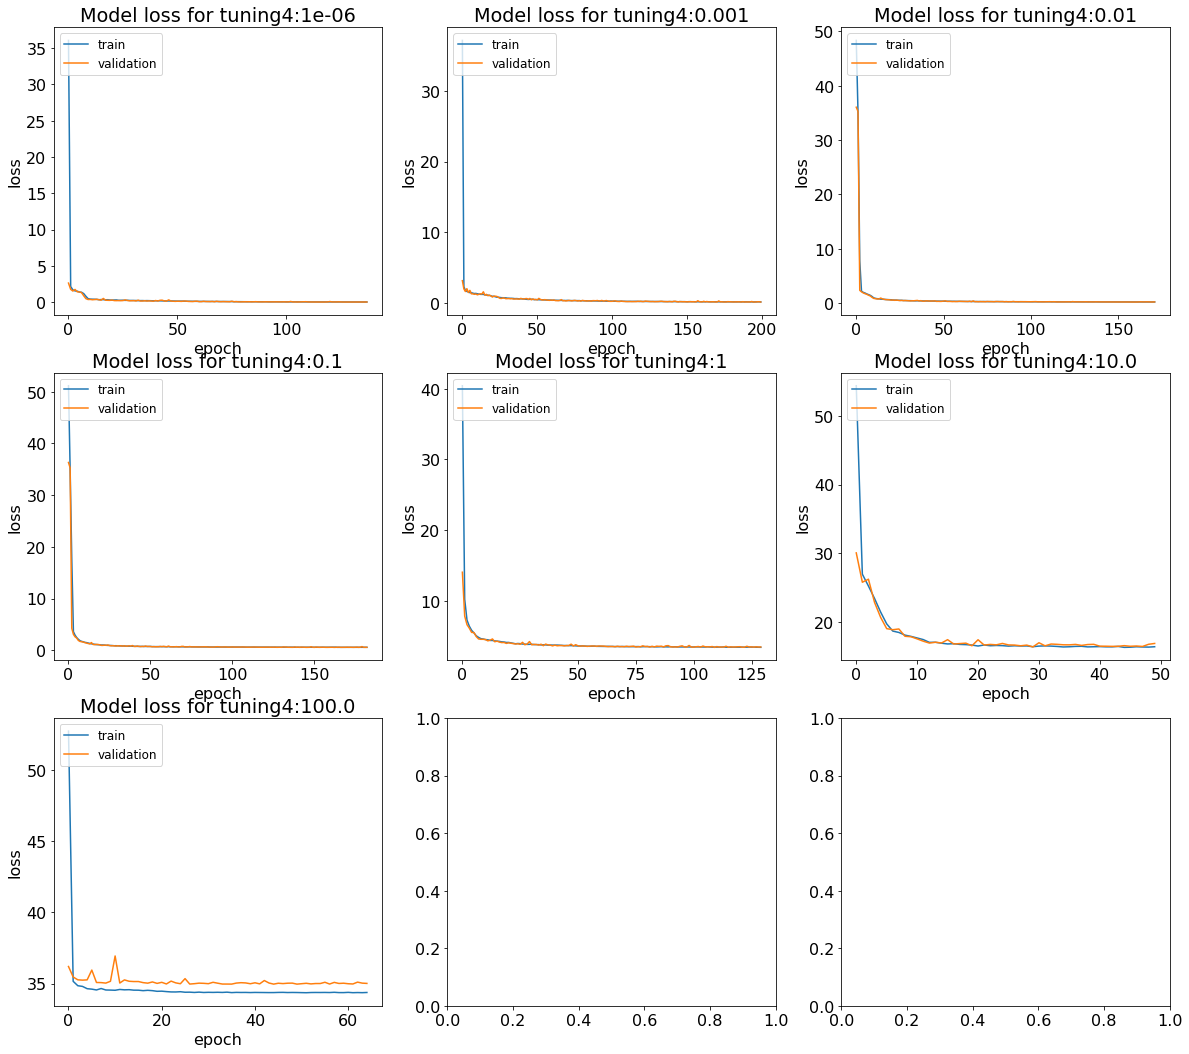

In [15]:
# Grid serach to find the best ratio between mse loss and KL-divergence in vae loss, the ratio is controlled by tuning parameter 4 in self-defined vae loss.
grid_result = {}

epoch_num = 200
verbose = 0
num_val_pred = 100
tuning4_grid = [1e-6, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]

if AMOC_range == 140:
    kernel_size = 60
    stride_enc = (7,4,4,3)
    stride_dec = (7,4,4,3)
elif AMOC_range == 70:
    kernel_size = 80
    stride_enc = (7,4,2,3)
    stride_dec = (7,4,3,2)
else:
    print('Need to define kernel size and stride size')

nrows = math.ceil(len(tuning4_grid)/3)
fig, axs = plt.subplots(nrows = nrows, ncols = 3, figsize = (20, 6*nrows))

for i, para in enumerate(tuning4_grid):
    print('para:', para)
    # fit the model
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    es = [
    EarlyStopping(patience=20, verbose=verbose, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True),
    ModelCheckpoint(filepath=hyper_path+'beta_'+str(para)+'.hdf5', save_freq='epoch', save_best_only=True)]
    vae_model = get_model(AMOC_input_train_scaled.shape[1:], AMOCindex_input_train_scaled.shape[1:], target_train_scaled.shape[1:], 
                          kernel_size = kernel_size, stride_enc = stride_enc, stride_dec = stride_dec, tuning4_para = para)
    history = vae_model.fit([AMOC_input_train_scaled, AMOCindex_input_train_scaled, target_train_scaled], batch_size=128, epochs=epoch_num, validation_split=0.2, verbose=verbose, callbacks=es)
    
    # prediction on validation set
    val_pred = np.zeros((num_val_pred, target_val_scaled.shape[0], target_val_scaled.shape[1], target_val_scaled.shape[2]))
    for j in range(num_val_pred):
        val_pred[j, :, :, :] = AMOC_scaler.inverse_transform(vae_model.predict([AMOC_input_val_scaled, AMOCindex_input_val_scaled, np.zeros(target_val_scaled.shape)], verbose = 0))
#         if j%10 == 0:
#             print(j)
        
    # record summary statistics
    val_pred = np.squeeze(val_pred)
    mean = np.mean(val_pred, axis = 0)
    lower_q = np.quantile(val_pred, 0.025, axis = 0)
    upper_q = np.quantile(val_pred, 0.975, axis = 0)
#     std = np.std(val_pred, axis = 0)

    grid_result[para] = [mean, lower_q, upper_q]
    
    # Visualize Model Training History
    axs[i//3, i%3].plot(history.history['loss'])
    axs[i//3, i%3].plot(history.history['val_loss'])
    axs[i//3, i%3].set_title('Model loss for tuning4:' + str(para))
    axs[i//3, i%3].set_ylabel('loss')
    axs[i//3, i%3].set_xlabel('epoch')
    axs[i//3, i%3].legend(['train', 'validation'], loc='upper left')

plt.show()

# fig.savefig(hyper_path+'history.png', bbox_inches='tight')
# np.save(outDATA_path+'grid_result.npy', grid_result)

In [16]:
# load grid_result file
# grid_result = np.load(outDATA_path+'grid_result.npy', allow_pickle=True)
# grid_result = grid_result[()]

# target = np.squeeze(AMOC_scaler.inverse_transform(target_val))
target = np.squeeze(target_val)

# np.save(outDATA_path+'val_target.npy', target)

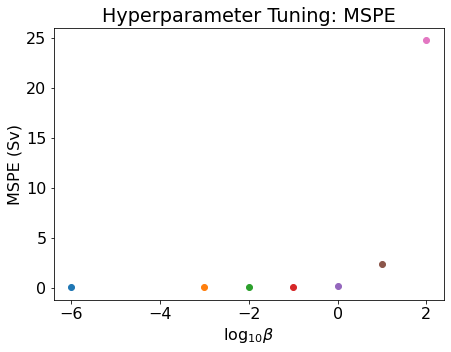

In [17]:
# plot mspe based on validation data
fig = plt.figure(figsize=(7, 5))
for key in grid_result:
    val_pred_mean = grid_result[key][0]
    mspe = np.mean(np.square(target - val_pred_mean))
    plt.plot(math.log10(key), mspe, marker = 'o')
#     plt.plot(math.log10(key), math.log10(mspe), marker = 'o')
plt.title('Hyperparameter Tuning: MSPE')
plt.xlabel(r'$\log_{10} \beta$')
plt.ylabel('MSPE (Sv)')
# plt.ylim((0, 2))
plt.show()

fig.savefig(hyper_path+'mspe.png', bbox_inches='tight')

In [18]:
# plot empirical coverage based on validation data set

labels = []
emp_coverage = []
mae = []

for key in grid_result:
    # calculate empirical probability over validation data set
    mean = grid_result[key][0]
#     std = grid_result[key][1]
#     ci = 1.96 * std
#     lower = mean - ci
#     upper = mean + ci
    lower = grid_result[key][1]
    upper = grid_result[key][2]
    count = np.sum((target >= lower) & (target <= upper), axis = 1)
    emp_prob = count/target_val.shape[1]
    
    # calculate mae over validation data set
    val_bias = np.mean(np.absolute(target - mean), axis=1)
    
    labels.append(math.log10(key))
    emp_coverage.append(emp_prob)
    mae.append(val_bias)

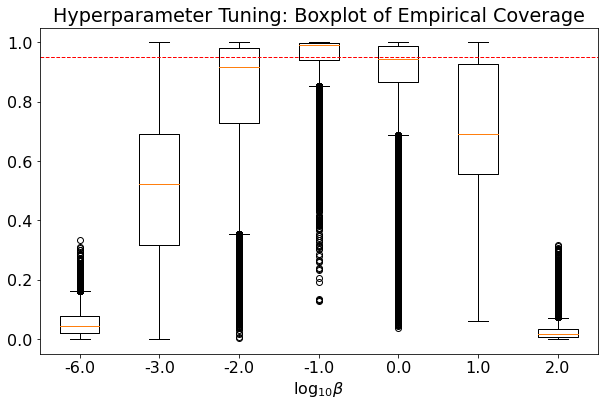

In [19]:
# plot empirical coverage based on validation data set
fig = plt.figure(figsize=(10, 6))
plt.boxplot(emp_coverage,
            positions=list(range(len(labels))),
            labels=labels)
plt.axhline(y=0.95, color='red', linestyle='--', lw=1)
plt.title('Hyperparameter Tuning: Boxplot of Empirical Coverage')
plt.xlabel(r'$\log_{10} \beta$')
plt.show()

fig.savefig(hyper_path+'box_emp_coverage.png', bbox_inches='tight') 

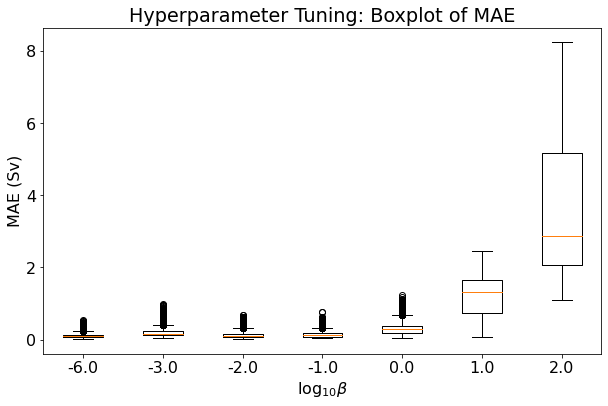

In [20]:
# plot mae based on validation data set
fig = plt.figure(figsize=(10, 6))
plt.boxplot(mae,
            positions=list(range(len(labels))),
            labels=labels)
plt.title('Hyperparameter Tuning: Boxplot of MAE')
plt.xlabel(r'$\log_{10} \beta$')
plt.ylabel('MAE (Sv)')
plt.show()

fig.savefig(hyper_path+'box_mae.png', bbox_inches='tight')

In [21]:
best_para = 0.1

In [22]:
# path to save model output: folder 'model_output' will not be shown on git 
# repo as the file is large, no need to git it.
file = outDATA_path+'beta_' + str(best_para) + '/'

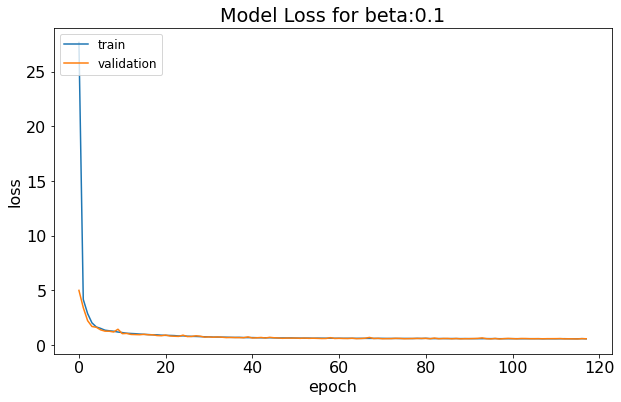

In [24]:
# train model with best hyper parameter

# combine training and validation data
AMOC_input_train_scaled = np.concatenate((AMOC_input_train_scaled, AMOC_input_val_scaled), axis = 0)
AMOCindex_input_train_scaled = np.concatenate((AMOCindex_input_train_scaled, AMOCindex_input_val_scaled), axis = 0)
target_train_scaled = np.concatenate((target_train_scaled, target_val_scaled), axis = 0)

# train model
epoch_num = 200
verbose = 0

tf.keras.backend.clear_session()
tf.random.set_seed(seed)
es = [
EarlyStopping(patience=20, verbose=verbose, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True),
ModelCheckpoint(filepath=hyper_path+'best_model_beta_'+str(best_para)+'.hdf5', save_freq='epoch', save_best_only=True)]
vae = get_model(AMOC_input_train_scaled.shape[1:], AMOCindex_input_train_scaled.shape[1:], target_train_scaled.shape[1:], 
                kernel_size = kernel_size, stride_enc = stride_enc, stride_dec = stride_dec, tuning4_para = best_para)
history = vae.fit([AMOC_input_train_scaled, AMOCindex_input_train_scaled, target_train_scaled], batch_size=128, epochs=epoch_num, validation_split=0.2, verbose=verbose, callbacks=es)

# Visualize Model Training History
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss for beta:' + str(best_para))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

np.save(file + 'history.npy', history.history)
fig.savefig(hyper_path+'best_model_beta_'+str(best_para)+'_history.png', bbox_inches='tight')

In [ ]:
# ATTENTION: prediction for test data set 'test_pred' need 421. GiB memory, 
# ensure have enough space.

In [25]:
vae = load_model(hyper_path+'best_model_beta_'+str(best_para)+'.hdf5')

# Pred testing data set, prediction results should be in original scale
test_pred = np.zeros((1000, target_test_scaled.shape[0], target_test_scaled.shape[1], target_test_scaled.shape[2]))

tf.random.set_seed(seed+1)
for i in range(1000):
    test_pred[i, :, :, :] = AMOC_scaler.inverse_transform(vae.predict([AMOC_input_test_scaled, AMOCindex_input_test_scaled, np.zeros(target_test_scaled.shape)], verbose = 0))
    
    if i%100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900


In [26]:
# # ATTENTION: prediction for test data set 'test_pred' need 421. GiB memory, 
# # ensure have enough space.

# np.save(file + 'test_pred.npy', test_pred)

[]

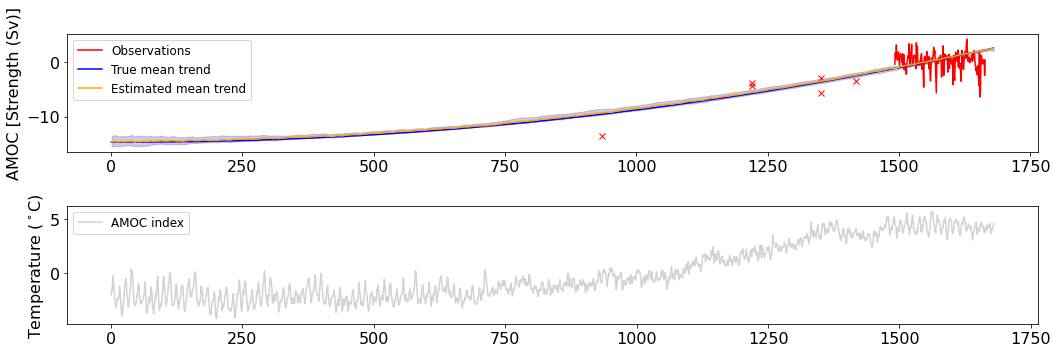

In [27]:
# plot some case in testing data set

i = 1000

test_pred_1000 = test_pred[:, i, :, :]
AMOC_input_test_0 = AMOC_input_test[i, :, :]
AMOCindex_input_test_0 = AMOCindex_input_test[i, :, :]
target_test_0 = target_test[i, :, :]

assert debug(AMOC_input_test, AMOC_input_test_scaled, AMOC_scaler)
assert debug(AMOCindex_input_test, AMOCindex_input_test_scaled, AMOCindex_scaler)
assert debug(target_test, target_test_scaled, AMOC_scaler)

test_pred_1000 = np.squeeze(test_pred_1000)
AMOC_input_test_0 = np.squeeze(AMOC_input_test_0)
AMOCindex_input_test_0 = np.squeeze(AMOCindex_input_test_0)
target_test_0 = np.squeeze(target_test_0)

### confidence interval ###
test_pred_1000 = np.squeeze(test_pred_1000)
mean = np.mean(test_pred_1000, axis=0)
lower = np.quantile(test_pred_1000, 0.025, axis = 0)
upper = np.quantile(test_pred_1000, 0.975, axis = 0)
# std = np.std(test_pred_1000, axis=0)
# ci = 1.96 * std
x = np.linspace(1, test_pred_1000.shape[1], test_pred_1000.shape[1])

mask = np.array(~AMOC_Obs['Obs'].isna())

foo = plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.tight_layout(pad = 2)
for j in range(6):
    plt.plot(x[mask][j], AMOC_input_test_0[j], c='red', marker='x')
plt.plot(x[mask][6:], AMOC_input_test_0[6:], c='red', label='Observations')
plt.plot(target_test_0, c='blue', label='True mean trend')
plt.plot(mean, c='orange', label='Estimated mean trend')
plt.fill_between(x, lower, upper, color='navy', alpha=.2)
plt.ylabel(r'AMOC [Strength (Sv)]')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(AMOCindex_input_test_0, c='lightgray', label='AMOC index')
plt.ylabel('Temperature ($^\circ$C)')
plt.legend()

plt.plot()

In [28]:
# save some representative testing data case
for i in [0, 1000, 4000, 8000, 10000]:
    np.save(file + 'test_pred_'+str(i)+'.npy', test_pred[:, i, :, :])
    np.save(file + 'AMOC_input_test_'+str(i)+'.npy', AMOC_input_test[i, :, :])
    np.save(file + 'AMOCindex_input_test_'+str(i)+'.npy', AMOCindex_input_test[i, :, :])
    np.save(file + 'target_test_'+str(i)+'.npy', target_test[i, :, :])

In [29]:
### pred Observation data, prediction results should be in original scale ###
AMOC_Obs = np.array(AMOC_Obs.loc[~AMOC_Obs['Obs'].isna(), 'Obs']).reshape((1, -1, 1))
AMOC_Obs = AMOC_Obs - AMOC_Obs.mean()
AMOC_Obs_scaled = AMOC_scaler.transform(AMOC_Obs)

AMOCindex_Obs = np.array(AMOCindex_Obs[['Obs']]).reshape((1, -1, 1))
AMOCindex_Obs = AMOCindex_Obs - AMOCindex_Obs.mean()
AMOCindex_Obs_scaled = AMOCindex_scaler.transform(AMOCindex_Obs)

# debugger to check if AMOC and AMOC index observation data is in 0-1 range
assert np.min(AMOC_Obs_scaled) > 0
assert np.max(AMOC_Obs_scaled) < 1
assert np.min(AMOCindex_Obs_scaled) > 0
assert np.max(AMOCindex_Obs_scaled) < 1

Obs_pred = np.zeros((1000, target_test_scaled.shape[1], target_test_scaled.shape[2]))

tf.random.set_seed(seed+2)
for i in range(1000):
    Obs_pred_0 = AMOC_scaler.inverse_transform(vae.predict([AMOC_Obs_scaled, AMOCindex_Obs_scaled, np.zeros((1, target_test_scaled.shape[1], target_test_scaled.shape[2]))], verbose = 0))
    Obs_pred[i, :, :] = np.squeeze(Obs_pred_0, axis = 0)

In [30]:
np.save(file + 'Obs_pred.npy', Obs_pred)

In [31]:
# Get emp_prob: for each testing data set, find confidence interval over 1,000 trails prediction generated from vae, check if target value is in constructed confidence interval. 
# The ideal empircal probability should be 0.95 as we are constructing 95% CI.
# target = np.squeeze(AMOC_scaler.inverse_transform(target_test)) # shape: (28,000, 840)
target = np.squeeze(target_test) 
assert debug(target_test, target_test_scaled, AMOC_scaler)
test_pred_1000 = np.squeeze(test_pred)

# emp_prob
mean = np.mean(test_pred_1000, axis=0)
lower = np.quantile(test_pred_1000, 0.025, axis = 0)
upper = np.quantile(test_pred_1000, 0.975, axis = 0)
# std = np.std(test_pred_1000, axis=0)
# ci = 1.96 * std
# lower = mean - ci
# upper = mean + ci
count = np.sum((target >= lower) & (target <= upper), axis = 1)
emp_prob = count/target_test.shape[1]

# bias
test_bias = target - mean

In [32]:
np.save(file + 'emp_prob.npy', emp_prob)
np.save(file + 'test_bias.npy', test_bias)
np.save(file + 'test_pred_mean.npy', mean)
np.save(file + 'test_pred_lower_q.npy', lower)
np.save(file + 'test_pred_upper_q.npy', upper)